In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

import numpy as np 
import pandas as pd
import torch
from main import *

from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GMM
from sklearn.cluster import KMeans

from model import * 
#to supress depreciation warnings 
import warnings; warnings.simplefilter('ignore')

(60, 118)

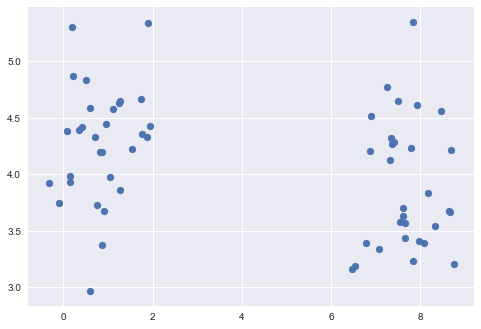

In [2]:
X, y_true = make_blobs(n_samples=60, n_features = 118, centers=2,
                       cluster_std=0.60, random_state=0)
# X = X[:, ::-1] # flip axes for better plotting

plt.scatter(X[:,0], X[:,1])
X.shape

(60, 118)
(60,)


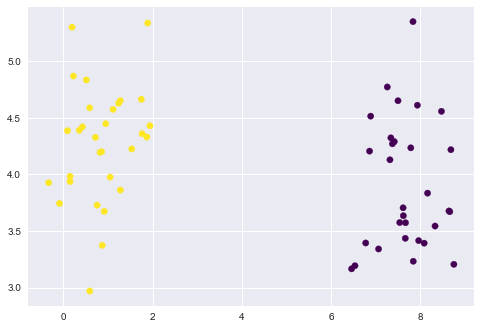

In [3]:
gmm = GMM(n_components=2).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
print(X.shape)
print(labels.shape)

# PR and F-Score for GMM 

In [4]:
from sklearn.metrics import precision_recall_fscore_support as prf 

precision, recall, f_score, support = prf(y_true, labels, average='binary')
print("Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(precision,recall, f_score))

Precision : 0.0000, Recall : 0.0000, F-score : 0.0000


# Experimentation with DAGMM 

In [5]:
lambda_energy = 0.1 
lambda_cov_diag = 0.005 
num_epochs = 500
lr =  1e-4

In [6]:
model = DaGMM()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
gamma_ls = [] 
for i in range(num_epochs): 
#     X, y_true = make_blobs(n_samples=60, n_features = 118, centers=2,
#                        cluster_std=0.60, random_state=0)
    X, y_true = make_blobs(n_samples=60, n_features = 118, centers=2,
                       cluster_std=0.60)
    X = to_var(torch.tensor(X, dtype=torch.float))
    
    enc, dec, z, gamma = model.forward(X)
    total_loss, sample_energy, recon_error, cov_diag = model.loss_function(X, dec, z, gamma,lambda_energy,lambda_cov_diag)
    gamma_ls.append(gamma.detach().numpy())
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step() 
#     print(model.mu.numpy())
#     print(model.cov.numpy())

# PR and F-Score for DAGMM       

In [7]:
# Testing the precision recall score on test data 
X_test, y_test = make_blobs(n_samples=60, n_features = 118, centers=2,
                       cluster_std=0.60)
X_test = to_var(torch.tensor(X_test, dtype=torch.float))
enc, dec, z, gamma = model.forward(X_test)

labels = [] 
new_gamma = gamma.detach().numpy()

for i in range(new_gamma.shape[0]):
    cluster_one_id = new_gamma[i][0]
    cluster_two_id = new_gamma[i][1]
    if (cluster_one_id <= cluster_two_id):
        labels.append(0)
    else:
        labels.append(1)
        
assert(len(labels) == new_gamma.shape[0])

precision, recall, f_score, support = prf(y_test, labels, average='binary')
print("Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(precision,recall, f_score))

Precision : 0.6765, Recall : 0.7667, F-score : 0.7188


In [8]:
print(labels)

[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]


In [9]:
print(y_test)

[0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1
 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1]
